# Paper: **COVID-19 Case Prediction in Virginia Based On Demographic Factors**
## Authors: Saiteja Bevara, Rithik Yelisetty and William Zhang (Code available at https://github.com/rithik/COVID-19-VA-Predictions)

### presented by Insightful Interfaces



In [ ]:
#import necessary modules
import os
import heapq
import re
import json
import string
import math
import random
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt

from itertools import chain

In [ ]:
# Import necessary Tensorflow and Keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.python.client import device_lib

# Tells us about GPU assigned by Colab
print(device_lib.list_local_devices()) # list of DeviceAttributes

# Set random seed to ensure consistent shuffling
tf.compat.v1.enable_eager_execution()
tf.random.set_seed(
    42
)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16619081476978447313
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8205564492162355443
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14882431389770942081
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146598848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8143334522518478001
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## 1. Why demographic data?
People have made various claims regarding how different demographics have affected the trends regarding the spread of COVID-19. Prominent predictions that are noted in common media outlets have been based primarily on previous case counts. We want our predictions for the spread of COVID-19 to include demographic data and income in order to better predict the next hotspots in the state of Virginia.

## 2. What is our dataset comprised of?
We used three primary datasets in order to train our model. Data regarding COVID-19 cases (per locality) was sourced from https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr/data. Socioeconomic data such as unemployment rate and median household income (per locality) was obtained from https://data.ers.usda.gov/reports.aspx?ID=17828. Demographic data regarding distribution of age and race was collected from https://www.cdc.gov/nchs/nvss/bridged_race.htm#Newest%20Data%20Release. All of this data was combined based on the FIPS code (unique per locality).

## 3. What is our goal?
Predict future cases of COVID-19 based on past confirmed case count as well as the population and demographics of the area in Virginia. The factors / model features that will be considered will be case count, along with demographic data such as population density, race distribution, age group distribution, median income and unemployment rate. The output or label assigned will be predicted number of new cases expected for the next day.


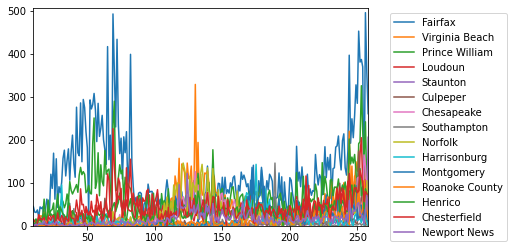

In [13]:
def make_covid_graph(path):
    x = pd.read_csv(path).sort_values(by=['report-date'])
    y = x[['c1']].astype('float32')
    counties = list(set(x['locality']))
    max_case_counts = list()
    for county in counties:
        max_case_counts.append((int(max(y.loc[x['locality'] == county].values)), county))
    counties_to_plot = sorted(max_case_counts, reverse=True)[:15]
    min_x = 1000
    max_x = 0
    max_y = 0
    for max_case, county in counties_to_plot:
        x_sel = x[x['locality'] == county]['num-days'].astype('int')
        temp = min(x_sel)
        if min_x > temp:
            min_x = temp
        temp = max(x_sel)
        if max_x < temp:
            max_x = temp
        y_sel = y.loc[x['locality'] == county].astype('float32')
        temp = float(max(y_sel.values))
        if max_y < temp:
            max_y = temp
        plt.plot(x_sel, y_sel, '-', label=county)
    plt.ylim(0, max_y + 10)
    plt.xlim(min_x, max_x)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')
    plt.show()

make_covid_graph('dataset.csv')

This graph shows the trend of COVID-19 cases for a few sample counties in Virginia. As visible by the data, each county has its own unique trajectory in terms of cases.

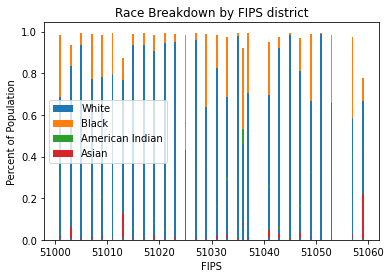

In [5]:
def make_race_graph(path):
    df = pd.read_csv(path).sort_values(by=['report-date'])
    df = df[df['report-date'] == '2020-11-30']

    df = df[df['fips'] <= 51060]
    x = df[['fips', 'white', 'black', 'american-indian', 'asian']].to_numpy().astype('float32')

    labels = df['fips'].to_numpy()

    white = df['white'].to_numpy()
    black = df['black'].to_numpy()
    ai = df['american-indian'].to_numpy()
    asian = df['asian'].to_numpy()

    width = 0.35       # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, white, width, label='White')
    ax.bar(labels, black, width, bottom=white,
        label='Black')
    ax.bar(labels, ai, width, bottom=black,
        label='American Indian')
    ax.bar(labels, asian, width, bottom=ai,
        label='Asian')

    ax.set_xlabel("FIPS")
    ax.set_ylabel('Percent of Population')
    ax.set_title('Race Breakdown by FIPS district')
    ax.legend()

    plt.show()
make_race_graph('dataset.csv')

This graph shows the breakdown of the population for a few sample FIPS districts based on race.  As displayed, there is a considerable amount of variance in the race distributions among the populations of each district.

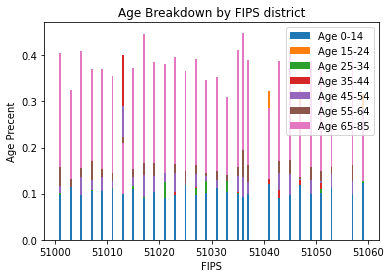

In [6]:
def make_age_graph(path):
    df = pd.read_csv(path).sort_values(by=['report-date'])
    df = df[df['report-date'] == '2020-11-30']

    df = df[df['fips'] <= 51060]
    x = df[['fips', 'age0-14', 'age15-24', 'age25-34', 'age35-44', 'age45-54', 'age55-64', 'age65-85']].to_numpy().astype('float32')

    labels = df['fips'].to_numpy()

    a0 = df['age0-14'].to_numpy()
    a1 = df['age15-24'].to_numpy()
    a2 = df['age25-34'].to_numpy()
    a3 = df['age35-44'].to_numpy()
    a4 = df['age45-54'].to_numpy()
    a5 = df['age55-64'].to_numpy()
    a6 = df['age65-85'].to_numpy()

    width = 0.35       

    fig, ax = plt.subplots()

    ax.bar(labels, a0, width, label='Age 0-14')
    ax.bar(labels, a1, width, bottom=a0,
        label='Age 15-24')
    ax.bar(labels, a2, width, bottom=a1,
        label='Age 25-34')
    ax.bar(labels, a3, width, bottom=a2,
        label='Age 35-44')
    ax.bar(labels, a4, width, bottom=a3,
        label='Age 45-54')
    ax.bar(labels, a5, width, bottom=a4,
        label='Age 55-64')
    ax.bar(labels, a6, width, bottom=a5,
        label='Age 65-85')

    ax.set_xlabel("FIPS")
    ax.set_ylabel('Age Precent')
    ax.set_title('Age Breakdown by FIPS district')
    ax.legend()

    plt.show()
make_age_graph('dataset.csv')

This graph shows the breakdown of the population for a few sample FIPS districts based on age.  As displayed, there is again a significant amount of variance in the age distributions among the populations of each district.

## Load Data

Once the dataset has been created, we need to import select columns from the entire dataset. Below, we use the pandas library to sort all of the data by the `report date`. 

For the y set, we choose the `c1` column.  The `c1` column represents the current day's number of COVID-19 cases. 

For the x set, we select the following columns for each datapoint in the x set: `fips`, `unemployment-percent`, `median-household-income`, `num-days`, `age0-14`, `age15-24`, `age25-34`, `age35-44`, `age45-54`, `age55-64`, `age65-85`, `white`, `black`, `american-indian`, `asian`, `total`, `c2`, `c3`,  `c4`, `c5`, `c6`, `c7`, `c8`, `c9` and `c10`, where each age column represents a percent of the population that consists of this age group, each race column represents the percent of the population that falls into a specific race and each `c` column represents the number of COVID-19 cases for days prior to `c1`, with a higher number representing older days. 

The data is then shuffled and split into train and test datasets, where 90% of the data is used for training and 10% is used for testing.

In [ ]:
def load_data(path):
    df = pd.read_csv(path).sort_values(by=['report-date'])
    x = df[['fips', 'unemployment-percent', 'median-household-income', 'num-days', 
            'age0-14', 'age15-24', 'age25-34', 'age35-44', 'age45-54', 'age55-64', 'age65-85', 'white', 'black',
            'american-indian', 'asian', 'total', 'c2', 'c3',  'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10']].to_numpy().astype('float32')
    y = df[['c1']].to_numpy().astype('float32')
    x, y = sklearn.utils.shuffle(x, y)
    train_test_split = int(x.shape[0] * 0.9)
    x_train = x[:train_test_split]
    y_train = y[:train_test_split]
    x_test = x[train_test_split:]
    y_test = y[train_test_split:]
    return x_train, x_test, y_train, y_test

## Model Creation

### Soft Accuracy
The `soft_acc` function represents our model's accuracy metric. A traditional accuracy metric would compare the predicted case count strictly to the true case count to see if they are explicitly equal. However, we wanted to provide leniancy to our model and therefore decided to use this function to classify an accurate prediction as one that falls within a certain threshold of cases. In this scenario, our threshold was 1 case. 

The `soft_acc` function subtracts the true case count from the predicted case count and checks if the difference is less than the threshold (1.0). If it is, it marks the prediction as accurate. Otherwise, the prediction is marked as inaccurate.

In [7]:
def soft_acc(y_true, y_pred):
    difference = tf.math.subtract(y_true, y_pred)
    def equaler(t): return 1.0 if t < 1.0 else 0.0
    bools = K.map_fn(equaler, difference)
    val = K.mean(bools)
    return val


### MLP Model

In order to solve this problem, the team decided to use an MLP model. We used a sequential model to run data through each of the layers. The first layer, as well as subsequent hidden layers, use the `relu` activation function and have units of size `hidden_dim`. There is an additional dropout layer after all of the hidden layers to remove all of the extraneous points to improve model generalization. The last layer uses a `linear` activation function and has only 1 unit because we only predict one value: case count. We used a `linear` activation function since our problem is primarily a regression-based problem with numerical output. The optimizer was specified by `args['opt']` and was selected with hyperparameter tuning. The loss function selected was Mean Squared Logarithmic Error. 



In [ ]:
def create_mlp(args=None):
    model = Sequential()
    # Define model architecture
    model.add(Dense(units=args['hidden_dim'],
                    activation='relu', input_dim=args['x_train_shape'][1]))  # 42
    for k in range(args['hidden_layer']):
        model.add(Dense(units=args['hidden_dim'], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='linear'))
    # Optimizer
    optimizer = keras.optimizers.SGD(lr=args['learning_rate']) if args['opt'] == 'sgd' else keras.optimizers.Adam(lr=args['learning_rate'])
    # Compile
    model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=optimizer, metrics=[soft_acc])

    return model

## Model Training and Selection

### Training the Model

The model was created using the args specified and subsequently fit on the `x_train` and `y_train` data. Shuffling was ensured by using the `shuffle=True` parameter to the `model.fit` method and a `validation_split` of 0.1 was used to specify the portion of the data to be used as a validation set.


In [ ]:
def train_model(x_train, y_train, args):
    model = create_mlp(args)
    history = model.fit(x_train, y_train, batch_size=args['batch_size'], epochs=args['epoch'], validation_split=0.1, shuffle=True)
    return model, history

### Model Selection

The following parameters were tested for each argument: 

`learning_rate`: 0.0000005, 0.0000003, 0.000001, 0.00005, 0.0001

`opt`: 'adam', 'sgd'

`epoch`: 5, 10, 20

`hidden_dim`: 10, 20, 50, 100, 200, 400

`hidden_layer`: 1, 2, 3, 5, 10, 15, 20, 30

For each set of parameters, the model was trained and fit to find the accuracy. The model with the highest resulting validation accuracy was chosen as the optimal model.

The best model consisted of the following parameters: 
```
args = {
        'batch_size': 8,
        'epoch': 20,
        'learning_rate': 0.0000005,
        'hidden_dim': 200,
        'hidden_layer': 20,
        'opt': 'adam',
        'x_train_shape': x_train.shape
}
```

In [ ]:
def train_and_select_model(x_train, y_train):
    args = {
        'batch_size': 8,
        'epoch': 20,
        'learning_rate': 0.0000005,
        'hidden_dim': 200,
        'hidden_layer': 20,
        'opt': 'adam',
        'x_train_shape': x_train.shape
    }
    best_acc = 0
    best_model = None
    best_history = None

    model, history = train_model(x_train, y_train, args=args)
    if history.history['val_soft_acc'][-1] >= best_acc:
        best_acc = history.history['val_soft_acc'][-1]
        best_model = model
        best_history = history
    return best_model, best_history

## Plot History

This method helps us understand whether the model is overfitting or underfitting the data. 

In [ ]:
def plot_history(history, plot_title=''):
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    train_acc_history = history.history['soft_acc']
    val_acc_history = history.history['val_soft_acc']
    plt.plot(range(len(train_loss_history)), train_loss_history, label='training_loss')
    plt.plot(range(len(val_loss_history)), val_loss_history, label='validation_loss')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training vs Validation Losses')
    plt.show()

    plt.plot(range(len(train_acc_history)), train_acc_history, label='training_accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='validation_accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.show()

[[5.1001e+04 3.5000e+00 4.2879e+04 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [5.1035e+04 3.6000e+00 4.1517e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.1678e+04 4.7000e+00 4.8726e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [5.1510e+04 2.1000e+00 9.9425e+04 ... 7.5000e+01 5.3000e+01 5.1000e+01]
 [5.1530e+04 2.7000e+00 4.3390e+04 ... 9.0000e+00 1.0000e+01 1.0000e+01]
 [5.1830e+04 3.9000e+00 5.2845e+04 ... 4.0000e+00 0.0000e+00 4.0000e+00]]
Epoch 1/20
Instructions for updating:
Use fn_output_signature instead
3328/3328 [==============================] - 35s 11ms/step - loss: 2.1042 - soft_acc: 0.5255 - val_loss: 0.9168 - val_soft_acc: 0.3694
Epoch 2/20
3328/3328 [==============================] - 35s 10ms/step - loss: 1.6278 - soft_acc: 0.4516 - val_loss: 0.9471 - val_soft_acc: 0.4208
Epoch 3/20
3328/3328 [==============================] - 35s 11ms/step - loss: 1.4210 - soft_acc: 0.4523 - val_loss: 0.9773 - val_soft_acc: 0.3806
Epoch 4/20
3328/3328 [==============================] - 36s

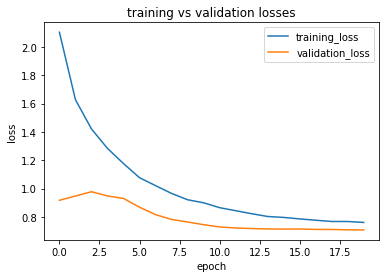

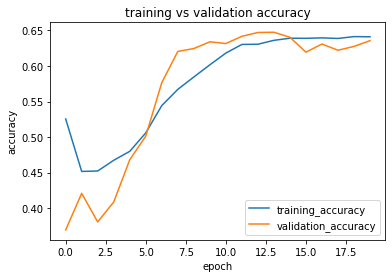

[[-0.40423787]
 [ 1.0429236 ]
 [ 0.7161754 ]
 ...
 [ 0.9868171 ]
 [97.18078   ]
 [97.2072    ]]
-------------------------------------------------
[[  0.]
 [  1.]
 [  0.]
 ...
 [  4.]
 [286.]
 [156.]]
103/103 [==============================] - 2s 17ms/step - loss: 0.7348 - soft_acc: 0.6447
0.7348275780677795 0.6446813344955444
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
__________________________________________________________

In [ ]:
path = 'dataset.csv'
x_train, x_test, y_train, y_test = load_data(path)
model, history = train_and_select_model(x_train, y_train)
plot_history(history)

loss_test, acc_test = model.evaluate(x_test, y_test)
print("Loss: {}, Accuracy: {}".format(loss_test, acc_test))

print(model.summary())

## Discussion of results

We found that the best performing MLP Model had the following parameters: Batch_size: 8, epoch: 20, learning_rate: 0.0000005, hidden_dim: 200, hidden_layer: 20, optimizer: adam. The validation accuracy was about 67% and the test accuracy was about 66%. The training and validation losses are decreasing and converging showing that our model is not overfit. The training and validation accuracies are increasing showing that our model is improving over time.

The baseline accuracy for this project, assuming random guessing, is less than ~0.2% (random guessing). In comparison, our model's accuracy of 65% is relatively high. The largest range of daily new COVID-19 case counts were in Fairfax County and case predictions, in general, ranged from 0 to about 500 cases. 

Further work could consider a larger number of demographic factors and take more factors into account (i.e. smoking, population density). 
Increasing the amount of data for each county or other demographic factors could increase accuracy. Certain input features were more indicative of a higher number of predicted cases. 



